In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 21:35:57.639538
thunder  Sun Dec 22 21:35:57 2019
[0] GeForce GTX 1080 Ti | 48'C,   0 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 51'C,  10 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 51'C,  23 % | 10895 / 11178 MB | patra(10885M)
[3] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 50'C,  23 % | 10895 / 11178 MB | patra(10885M)
[5] GeForce GTX 1080 Ti | 53'C,   0 % | 10895 / 11178 MB | patra(10885M)
[6] GeForce GTX 1080 Ti | 31'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 21:36:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 35%   49C    P2   130W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 37%   50C    P2    57W / 250W |  10895Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "3"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=100
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/100
50/50 [==============================] - 25s 502ms/step - loss: 0.7077 - Accuracy: 0.5788 - Precision: 0.5901 - Recall: 0.5940 - F1: 0.5781 - AUC: 0.6145 - val_loss: 2.2397 - val_Accuracy: 0.0531 - val_Precision: 0.0288 - val_Recall: 0.4000 - val_F1: 0.0521 - val_AUC: 0.6267
Epoch 2/100
50/50 [==============================] - 21s 419ms/step - loss: 0.6536 - Accuracy: 0.6231 - Precision: 0.6144 - Recall: 0.6407 - F1: 0.6215 - AUC: 0.6791 - val_loss: 2.6223 - val_Accuracy: 0.0188 - val_Precision: 0.0188 - val_Recall: 0.4000 - val_F1: 0.0353 - val_AUC: 0.6582
Epoch 3/100
50/50 [==============================] - 30s 604ms/step - loss: 0.6550 - Accuracy: 0.6388 - Precision: 0.6504 - Recall: 0.6603 - F1: 0.6451 - AUC: 0.6809 - val_loss: 1.2883 - val_Accuracy: 0.1000 - val_Precision: 0.0370 - val_Recall: 0.7000 - val_F1: 0.0700 - val_AUC: 0.5939
Epoch 4/100
50/50 [==============================] - 21s 427ms/step - loss: 0.6414 - Accuracy: 0.6394 - Precision: 0.6361 - Recall: 0.64

50/50 [==============================] - 21s 418ms/step - loss: 0.5224 - Accuracy: 0.7250 - Precision: 0.7046 - Recall: 0.7687 - F1: 0.7277 - AUC: 0.8188 - val_loss: 0.8437 - val_Accuracy: 0.4000 - val_Precision: 0.0292 - val_Recall: 0.4000 - val_F1: 0.0534 - val_AUC: 0.7216
Epoch 30/100
50/50 [==============================] - 25s 503ms/step - loss: 0.5263 - Accuracy: 0.7431 - Precision: 0.7257 - Recall: 0.7766 - F1: 0.7454 - AUC: 0.8161 - val_loss: 0.8364 - val_Accuracy: 0.4031 - val_Precision: 0.0098 - val_Recall: 0.2000 - val_F1: 0.0186 - val_AUC: 0.3800
Epoch 31/100
50/50 [==============================] - 22s 431ms/step - loss: 0.5268 - Accuracy: 0.7315 - Precision: 0.7305 - Recall: 0.7411 - F1: 0.7292 - AUC: 0.8157 - val_loss: 0.6513 - val_Accuracy: 0.5094 - val_Precision: 0.0541 - val_Recall: 0.6500 - val_F1: 0.0992 - val_AUC: 0.6625
Epoch 32/100
50/50 [==============================] - 25s 508ms/step - loss: 0.5068 - Accuracy: 0.7675 - Precision: 0.7543 - Recall: 0.7908 - F1: 

50/50 [==============================] - 21s 420ms/step - loss: 0.5357 - Accuracy: 0.7325 - Precision: 0.7428 - Recall: 0.7620 - F1: 0.7458 - AUC: 0.8042 - val_loss: 1.1474 - val_Accuracy: 0.3344 - val_Precision: 0.0367 - val_Recall: 0.6000 - val_F1: 0.0687 - val_AUC: 0.7815
Epoch 58/100
50/50 [==============================] - 22s 431ms/step - loss: 0.5193 - Accuracy: 0.7531 - Precision: 0.7476 - Recall: 0.7905 - F1: 0.7609 - AUC: 0.8251 - val_loss: 1.1335 - val_Accuracy: 0.3438 - val_Precision: 0.0272 - val_Recall: 0.4000 - val_F1: 0.0506 - val_AUC: 0.5285
Epoch 59/100
50/50 [==============================] - 26s 513ms/step - loss: 0.5397 - Accuracy: 0.7362 - Precision: 0.7209 - Recall: 0.7798 - F1: 0.7424 - AUC: 0.8048 - val_loss: 1.0889 - val_Accuracy: 0.3125 - val_Precision: 0.0045 - val_Recall: 0.1000 - val_F1: 0.0087 - val_AUC: 0.9295
Epoch 60/100
50/50 [==============================] - 21s 424ms/step - loss: 0.5241 - Accuracy: 0.7356 - Precision: 0.7140 - Recall: 0.7583 - F1: 

50/50 [==============================] - 26s 514ms/step - loss: 0.5278 - Accuracy: 0.7513 - Precision: 0.7483 - Recall: 0.7673 - F1: 0.7518 - AUC: 0.8182 - val_loss: 1.2350 - val_Accuracy: 0.2750 - val_Precision: 0.0467 - val_Recall: 0.7000 - val_F1: 0.0857 - val_AUC: 0.7408
Epoch 86/100
50/50 [==============================] - 20s 403ms/step - loss: 0.5095 - Accuracy: 0.7638 - Precision: 0.7587 - Recall: 0.7874 - F1: 0.7671 - AUC: 0.8347 - val_loss: 0.9843 - val_Accuracy: 0.2875 - val_Precision: 0.0255 - val_Recall: 0.6000 - val_F1: 0.0488 - val_AUC: 0.5461
Epoch 87/100
50/50 [==============================] - 21s 417ms/step - loss: 0.5376 - Accuracy: 0.7256 - Precision: 0.7163 - Recall: 0.7472 - F1: 0.7240 - AUC: 0.8041 - val_loss: 1.1562 - val_Accuracy: 0.2812 - val_Precision: 0.0342 - val_Recall: 0.5667 - val_F1: 0.0636 - val_AUC: 0.4851
Epoch 88/100
50/50 [==============================] - 26s 517ms/step - loss: 0.5249 - Accuracy: 0.7394 - Precision: 0.7103 - Recall: 0.7697 - F1: 

In [21]:
print("Time taken:",end-start)

Time taken: 2277.2738218307495


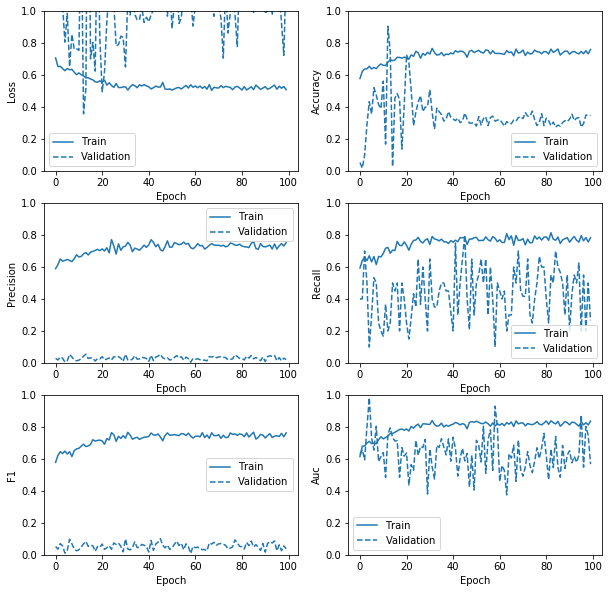

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps,
                              class_weight = {0:1.5,1:0.5},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/100
50/50 [==============================] - 26s 511ms/step - loss: 0.9595 - Accuracy: 0.6225 - Precision: 0.1849 - Recall: 0.8840 - F1: 0.2913 - AUC: 0.8444 - val_loss: 1.0526 - val_Accuracy: 0.3094 - val_Precision: 0.0311 - val_Recall: 0.3000 - val_F1: 0.0545 - val_AUC: 0.5625
Epoch 2/100
50/50 [==============================] - 20s 395ms/step - loss: 0.9028 - Accuracy: 0.6438 - Precision: 0.1787 - Recall: 0.7497 - F1: 0.2796 - AUC: 0.8212 - val_loss: 0.9485 - val_Accuracy: 0.2844 - val_Precision: 0.0232 - val_Recall: 0.3000 - val_F1: 0.0420 - val_AUC: 0.6672
Epoch 3/100
50/50 [==============================] - 21s 410ms/step - loss: 0.8403 - Accuracy: 0.6844 - Precision: 0.1890 - Recall: 0.7803 - F1: 0.2920 - AUC: 0.8344 - val_loss: 0.9367 - val_Accuracy: 0.2906 - val_Precision: 0.0371 - val_Recall: 0.5500 - val_F1: 0.0689 - val_AUC: 0.5836
Epoch 4/100
50/50 [==============================] - 24s 483ms/step - loss: 0.7641 - Accuracy: 0.7262 - Precision: 0.2382 - Recall: 0.79

50/50 [==============================] - 24s 487ms/step - loss: 0.3662 - Accuracy: 0.8938 - Precision: 0.3133 - Recall: 0.1533 - F1: 0.1950 - AUC: 0.7769 - val_loss: 0.6505 - val_Accuracy: 0.4969 - val_Precision: 0.0354 - val_Recall: 0.4000 - val_F1: 0.0632 - val_AUC: 0.6521
Epoch 30/100
50/50 [==============================] - 20s 396ms/step - loss: 0.3505 - Accuracy: 0.8938 - Precision: 0.3283 - Recall: 0.1608 - F1: 0.1993 - AUC: 0.8383 - val_loss: 0.7462 - val_Accuracy: 0.4812 - val_Precision: 0.0115 - val_Recall: 0.2000 - val_F1: 0.0218 - val_AUC: 0.3816
Epoch 31/100
50/50 [==============================] - 20s 405ms/step - loss: 0.3489 - Accuracy: 0.8956 - Precision: 0.3183 - Recall: 0.1898 - F1: 0.2101 - AUC: 0.8018 - val_loss: 0.6346 - val_Accuracy: 0.5219 - val_Precision: 0.0489 - val_Recall: 0.6000 - val_F1: 0.0898 - val_AUC: 0.6450
Epoch 32/100
50/50 [==============================] - 24s 480ms/step - loss: 0.3336 - Accuracy: 0.8975 - Precision: 0.3483 - Recall: 0.1965 - F1: 

50/50 [==============================] - 24s 481ms/step - loss: 0.2286 - Accuracy: 0.9131 - Precision: 0.1200 - Recall: 0.0350 - F1: 0.0540 - AUC: 0.8411 - val_loss: 0.5661 - val_Accuracy: 0.7250 - val_Precision: 0.0641 - val_Recall: 0.4500 - val_F1: 0.1074 - val_AUC: 0.7881
Epoch 58/100
50/50 [==============================] - 19s 388ms/step - loss: 0.2330 - Accuracy: 0.9181 - Precision: 0.1000 - Recall: 0.0333 - F1: 0.0490 - AUC: 0.7906 - val_loss: 0.5223 - val_Accuracy: 0.7688 - val_Precision: 0.0100 - val_Recall: 0.1000 - val_F1: 0.0182 - val_AUC: 0.5043
Epoch 59/100
50/50 [==============================] - 20s 396ms/step - loss: 0.2261 - Accuracy: 0.9144 - Precision: 0.1400 - Recall: 0.0397 - F1: 0.0607 - AUC: 0.8159 - val_loss: 0.4774 - val_Accuracy: 0.7844 - val_Precision: 0.0125 - val_Recall: 0.1000 - val_F1: 0.0222 - val_AUC: 0.8981
Epoch 60/100
50/50 [==============================] - 24s 481ms/step - loss: 0.2313 - Accuracy: 0.8975 - Precision: 0.1400 - Recall: 0.0412 - F1: 

50/50 [==============================] - 24s 485ms/step - loss: 0.1861 - Accuracy: 0.9125 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8365 - val_loss: 0.4462 - val_Accuracy: 0.9031 - val_Precision: 0.1750 - val_Recall: 0.1667 - val_F1: 0.1300 - val_AUC: 0.7061
Epoch 86/100
50/50 [==============================] - 19s 388ms/step - loss: 0.1790 - Accuracy: 0.9150 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8451 - val_loss: 0.3366 - val_Accuracy: 0.9187 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4749
Epoch 87/100
50/50 [==============================] - 20s 396ms/step - loss: 0.1813 - Accuracy: 0.9150 - Precision: 0.0400 - Recall: 0.0300 - F1: 0.0333 - AUC: 0.8401 - val_loss: 0.3848 - val_Accuracy: 0.8906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4937
Epoch 88/100
50/50 [==============================] - 25s 495ms/step - loss: 0.1872 - Accuracy: 0.9087 - Preci

In [24]:
print("Time taken:",end-start)

Time taken: 2146.298264503479


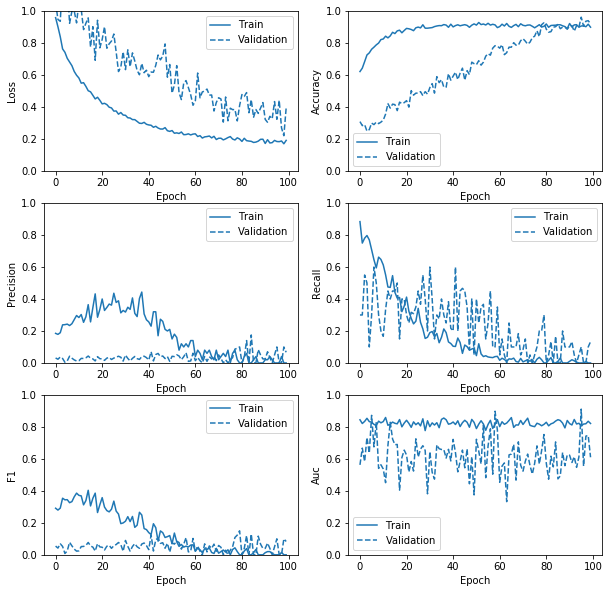

In [25]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:1.8,1:0.3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/100
50/50 [==============================] - 23s 455ms/step - loss: 0.1288 - Accuracy: 0.9556 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8337 - val_loss: 0.3556 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5514
Epoch 2/100
50/50 [==============================] - 25s 497ms/step - loss: 0.1299 - Accuracy: 0.9563 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8101 - val_loss: 0.3500 - val_Accuracy: 0.9187 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6170
Epoch 3/100
50/50 [==============================] - 21s 423ms/step - loss: 0.1257 - Accuracy: 0.9500 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8499 - val_loss: 0.3124 - val_Accuracy: 0.9187 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5681
Epoch 4/100
50/50 [==============================] - 21s 427ms/s

50/50 [==============================] - 21s 426ms/step - loss: 0.1017 - Accuracy: 0.9413 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8153 - val_loss: 0.1886 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6653
Epoch 28/100
50/50 [==============================] - 25s 506ms/step - loss: 0.0880 - Accuracy: 0.9550 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8405 - val_loss: 0.2408 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6611
Epoch 29/100
50/50 [==============================] - 20s 408ms/step - loss: 0.0931 - Accuracy: 0.9506 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8319 - val_loss: 0.1591 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6154
Epoch 30/100
50/50 [==============================] - 22s 442ms/step - los

50/50 [==============================] - 22s 441ms/step - loss: 0.0783 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8295 - val_loss: 0.2288 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5666
Epoch 54/100
50/50 [==============================] - 21s 428ms/step - loss: 0.0786 - Accuracy: 0.9550 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7866 - val_loss: 0.1694 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8092
Epoch 55/100
50/50 [==============================] - 24s 486ms/step - loss: 0.0806 - Accuracy: 0.9494 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8266 - val_loss: 0.1144 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4768
Epoch 56/100
50/50 [==============================] - 20s 404ms/step - los

50/50 [==============================] - 20s 404ms/step - loss: 0.0830 - Accuracy: 0.9450 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8061 - val_loss: 0.2020 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6474
Epoch 80/100
50/50 [==============================] - 23s 451ms/step - loss: 0.0746 - Accuracy: 0.9525 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8285 - val_loss: 0.1116 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7561
Epoch 81/100
50/50 [==============================] - 19s 386ms/step - loss: 0.0751 - Accuracy: 0.9513 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8290 - val_loss: 0.2084 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5873
Epoch 82/100
50/50 [==============================] - 20s 397ms/step - los

In [27]:
print("Time taken:",end-start)

Time taken: 2197.439261198044


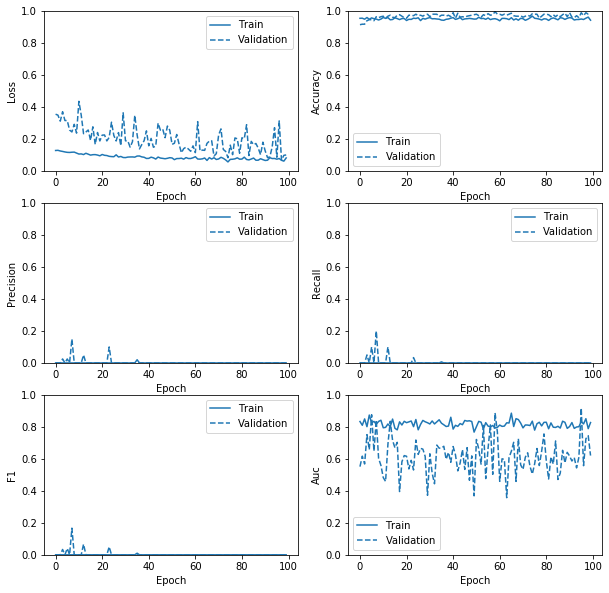

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = class_weight,
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [33]:
# print("Time taken:",end-start)

In [34]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 18s 185ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.168 :   0.076
Accuracy : 0.976 :   0.980
Precision : 0.000 :   0.000
Recall : 0.000 :   0.000
F1 : 0.000 :   0.000
AUC : 0.628 :   0.659


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1257.3016817569733, 198.99209880828857)

In [38]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [40]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

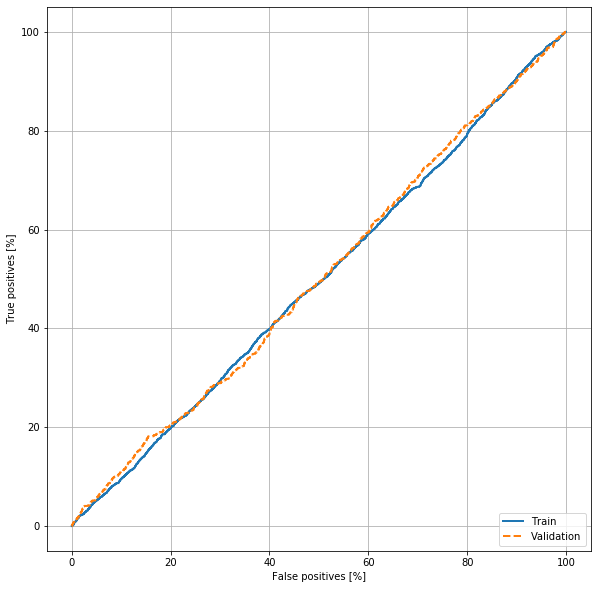

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 99450 
FP: 5 
FN: 2379 
TP: 0
Healthy Patients - correctly identified (True Negatives):  99450 0.9999497260067367
Healthy Patients - predicted to have glaucoma (False Positives):  5 5.0273993263284905e-05
Glaucoma Patients - predicted healthy (False Negatives):  2379 1.0
Glaucoma Patients - correctly identified (True Positives):  0 0.0

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


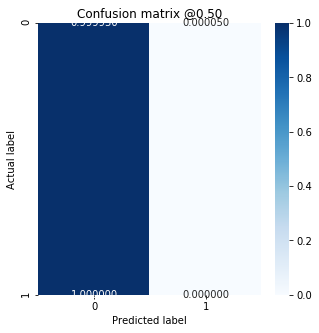

In [42]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33134 
FP: 0 
FN: 809 
TP: 0
Healthy Patients - correctly identified (True Negatives):  33134 1.0
Healthy Patients - predicted to have glaucoma (False Positives):  0 0.0
Glaucoma Patients - predicted healthy (False Negatives):  809 1.0
Glaucoma Patients - correctly identified (True Positives):  0 0.0

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


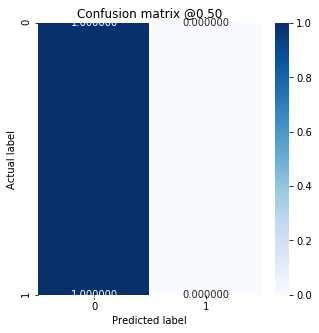

In [43]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [44]:
# history = up3_history
# tag_value = "trained twice bal and 1:10 and 1:20 with 78 tr layers with cw reverse of copy3"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [45]:
# client = MlflowClient()
# run = client.create_run('20')
# client.set_tag(run.info.run_id, "tag_key", tag_value)